<a href="https://colab.research.google.com/github/mahi97/MahiColabs/blob/master/BasicConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist

In [0]:
def montage_batch(images):
    """Draws all filters (n_input * n_output filters) as a
    montage image separated by 1 pixel borders.
    Parameters
    ----------
    batch : numpy.ndarray
        Input array to create montage of.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones(
        (images.shape[1] * n_plots + n_plots + 1,
         images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter, ...]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w, :] = this_img
    return m


# %%
def montage(W):
    """Draws all filters (n_input * n_output filters) as a
    montage image separated by 1 pixel borders.
    Parameters
    ----------
    W : numpy.ndarray
        Input array to create montage of.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    W = np.reshape(W, [W.shape[0], W.shape[1], 1, W.shape[2] * W.shape[3]])
    n_plots = int(np.ceil(np.sqrt(W.shape[-1])))
    m = np.ones(
        (W.shape[0] * n_plots + n_plots + 1,
         W.shape[1] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < W.shape[-1]:
                m[1 + i + i * W.shape[0]:1 + i + (i + 1) * W.shape[0],
                  1 + j + j * W.shape[1]:1 + j + (j + 1) * W.shape[1]] = (
                    np.squeeze(W[:, :, :, this_filter]))
    return m




# %%
def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float32))


# %%
def weight_variable(shape):
    '''Helper function to create a weight variable initialized with
    a normal distribution
    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)


# %%
def bias_variable(shape):
    '''Helper function to create a bias variable initialized with
    a constant value.
    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255
y_test = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_test]
y_train = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_train]

In [0]:
n_input = 28 * 28
n_output = 10
x = tf.placeholder(tf.float32, (None, n_input))
y = tf.placeholder(tf.float32, [None, n_output])

In [0]:
x_tensor = tf.reshape(x, [-1, 28, 28, 1])

In [6]:
filter_size = 5
n_filter_1 = 16
W_conv1 = weight_variable([filter_size, filter_size, 1, n_filter_1])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
b_conv1 = bias_variable([n_filter_1])

In [0]:
h_conv1 = tf.nn.relu(tf.nn.conv2d(input=x_tensor,
                                 filter=W_conv1,
                                 strides=[1, 2, 2, 1],
                                 padding='SAME') + b_conv1)

In [0]:
n_filter_2 = 16
W_conv2 = weight_variable([filter_size, filter_size, n_filter_1, n_filter_2])
b_conv2 = bias_variable([n_filter_2])
h_conv2 = tf.nn.relu(tf.nn.conv2d(input=h_conv1, filter=W_conv2,
                                 strides=[1, 2, 2, 1],
                                 padding='SAME') + b_conv2)


In [0]:
h_conv2_flat = tf.reshape(h_conv2, [-1, 7 * 7 * n_filter_2])

In [0]:
n_fc = 1024
W_fc1 = weight_variable([7 * 7 * n_filter_2, n_fc])
b_fc1 = bias_variable([n_fc])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

In [0]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, rate=1-keep_prob)

In [0]:
W_fc2 = weight_variable([n_fc, 10])
b_fc2 = bias_variable([10])
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [0]:
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))
optimzer = tf.train.AdamOptimizer().minimize(cross_entropy)

In [0]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
# %% We'll train in minibatches and report accuracy:
batch_size = 2000
n_epochs = 15
for epoch_i in range(n_epochs):
    print(epoch_i)
    print(sess.run(W_conv1[0][0]))
    for batch_i in range(X_train.shape[0] // batch_size):
      batch_xs = X_train[batch_i * batch_size: (batch_i + 1) * batch_size].reshape(batch_size,784)
      batch_ys = y_train[batch_i * batch_size: (batch_i + 1) * batch_size]
      sess.run(optimzer, feed_dict={
          x: batch_xs,
          y: batch_ys,
          keep_prob: 0.5})

0
[[ 0.00507283 -0.00269648  0.00412116  0.00309399  0.00324499 -0.00136309
   0.00467365 -0.00907443  0.02322942  0.01928053  0.00311181  0.0123429
   0.00264936 -0.0127928   0.01786472  0.00543135]]
1
[[0.03186198 0.02561832 0.0320567  0.02916002 0.02978736 0.0246903
  0.01890924 0.01719689 0.05219114 0.04772457 0.03211416 0.03751492
  0.0306192  0.0105187  0.04679749 0.03310122]]
2
[[0.03247388 0.02584895 0.03661871 0.03465554 0.03103321 0.02617758
  0.00023122 0.01883904 0.05669548 0.05297622 0.03462866 0.03867792
  0.02804921 0.00975788 0.04906905 0.03477598]]
3
[[ 0.03063766  0.02362281  0.03862723  0.03719939  0.02947689  0.0245999
  -0.00972312  0.01713319  0.0577906   0.05517092  0.03393043  0.03696658
   0.02424413  0.00735778  0.04814072  0.03399305]]
4
[[ 0.02944915  0.02209787  0.04095571  0.03974873  0.02854089  0.02345484
  -0.01571537  0.01571336  0.05906639  0.05743384  0.03341165  0.03602926
   0.02115533  0.00588435  0.04758027  0.03369556]]
5
[[ 0.02819758  0.020446

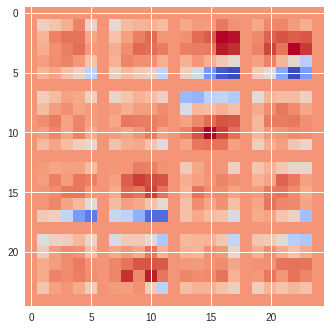

In [22]:
W = sess.run(W_conv1)
plt.imshow(montage(W / np.max(W)), cmap='coolwarm')

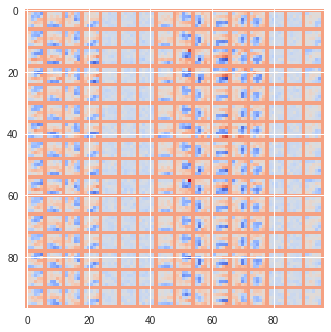

In [20]:
W = sess.run(W_conv2)
plt.imshow(montage(W / np.max(W)), cmap='coolwarm')

In [19]:
print(sess.run(accuracy,
                   feed_dict={
                       x: X_test.reshape(10000, 784),
                       y: y_test,
                       keep_prob: 1.0
                   }))

0.9785
